In [30]:
# ================= Reliability-Optimized SHAP Pipeline (CSV/ARFF, 8 models) =================
import warnings, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# numpy compat for some deps
if not hasattr(np, "bool"): np.bool = np.bool_
if not hasattr(np, "int"):  np.int  = int

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, brier_score_loss
from sklearn.calibration import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from scipy.io import arff

# optional libs
try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

def _try_import_xgb():
    try:
        from xgboost import XGBClassifier
        return XGBClassifier
    except Exception:
        return None

def _try_import_lgbm():
    try:
        from lightgbm import LGBMClassifier
        return LGBMClassifier
    except Exception:
        return None

def _try_import_cat():
    try:
        from catboost import CatBoostClassifier
        return CatBoostClassifier
    except Exception:
        return None

# ------------------------------- data loading -------------------------------
def load_data(path: str):
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith(".arff"):
        data, meta = arff.loadarff(path)
        df = pd.DataFrame(data)
        for c in df.select_dtypes(["object"]).columns:
            df[c] = df[c].apply(lambda x: x.decode("utf-8") if isinstance(x, (bytes, bytearray)) else x)
    else:
        raise ValueError(f"Unsupported file format: {path}")

    tgt = "Defective" if "Defective" in df.columns else df.columns[-1]
    y = df[tgt].copy()
    if y.dtype == bool: y = y.astype(int)
    if y.dtype.name == "object":
        y = y.replace({"true":1,"True":1,"yes":1,"Yes":1,"faulty":1,
                       "false":0,"False":0,"no":0,"No":0,"clean":0}).astype(int)

    X = df.drop(columns=[tgt]).copy()

    # drop constants + fill
    const = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if const: X.drop(columns=const, inplace=True)
    if X.isna().any().any():
        X = X.fillna(method="ffill").fillna(method="bfill")
        if X.isna().any().any(): X = X.fillna(0.0)
    return X, y.astype(int)

# ------------------------------- metrics -----------------------------------
def expected_calibration_error(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        m = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if m.any():
            ece += abs(y_true[m].mean() - y_prob[m].mean()) * (m.sum()/len(y_true))
    return float(ece)

def gini_from_scores(y_true, y_score):
    order = np.argsort(y_score)  # ascending for Lorenz
    y = np.asarray(y_true)[order]
    tot = y.sum()
    if tot <= 0: return 0.0
    frac_def = np.cumsum(y) / tot
    frac_pop = np.linspace(1/len(y), 1.0, len(y))
    area = np.trapz(frac_def, frac_pop)
    return (0.5 - area) / 0.5   # [-1,1]

def gini_to_unit(g):  # -> [0,1]
    return float(np.clip((g + 1.0) / 2.0, 0.0, 1.0))

# robust SHAP reducer
def _shap_to_2d_posclass(shap_values, n_features: int):
    if isinstance(shap_values, list):
        return np.asarray(shap_values[1] if len(shap_values) > 1 else shap_values[0])
    arr = np.asarray(shap_values)
    if arr.ndim == 2 and arr.shape[1] == n_features: return arr
    if arr.ndim == 3:
        feat_axes = [ax for ax, sz in enumerate(arr.shape) if sz == n_features]
        if feat_axes:
            arr = np.moveaxis(arr, feat_axes[0], -1)  # -> (n, ?, n_features)
            cls_dim = arr.shape[1]
            return arr[:, 1, :] if cls_dim >= 2 else arr[:, 0, :]
        if arr.shape[-1] == n_features: return arr
    return arr.reshape(arr.shape[0], n_features)

# ----------------------------- model factory -------------------------------
def make_single_model(name: str, random_state: int, input_dim: int, pos_ratio: float):
    n = name.strip().lower()
    if n in ("rf","random_forest","random-forest","randomforest"):
        return RandomForestClassifier(
            n_estimators=800, min_samples_leaf=2, class_weight="balanced_subsample",
            random_state=random_state, n_jobs=-1
        )
    if n in ("extra_trees","extratrees","et"):
        return ExtraTreesClassifier(
            n_estimators=900, min_samples_leaf=2, random_state=random_state, n_jobs=-1
        )
    if n in ("gradient_boosting","gbrt","gb"):
        return GradientBoostingClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=3, subsample=0.8, random_state=random_state
        )
    if n in ("adaboost","ada"):
        return AdaBoostClassifier(n_estimators=400, learning_rate=0.05, random_state=random_state)
    if n in ("xgboost","xgb"):
        XGB = _try_import_xgb()
        if XGB is None: raise ImportError("xgboost not installed.")
        spw = max(1.0, (1-pos_ratio)/max(1e-6, pos_ratio))
        return XGB(
            n_estimators=1200, max_depth=4, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
            reg_lambda=1.0, n_jobs=-1, objective="binary:logistic", random_state=random_state,
            eval_metric="logloss", tree_method="hist", scale_pos_weight=spw
        )
    if n in ("lightgbm","lgbm","lgb"):
        LGBM = _try_import_lgbm()
        if LGBM is None: raise ImportError("lightgbm not installed.")
        return LGBM(
            n_estimators=3000, learning_rate=0.02, subsample=0.8, colsample_bytree=0.8,
            num_leaves=31, objective="binary", random_state=random_state, n_jobs=-1
        )
    if n in ("catboost","cb"):
        Cat = _try_import_cat()
        if Cat is None: raise ImportError("catboost not installed.")
        return Cat(
            iterations=3000, learning_rate=0.03, depth=6, random_state=random_state,
            loss_function="Logloss", od_type="Iter", od_wait=200, verbose=False
        )
    if n in ("mlp","nn","pytorch_mlp"):
        from sklearn.neural_network import MLPClassifier
        return MLPClassifier(hidden_layer_sizes=(64,64), max_iter=300, early_stopping=True,
                             random_state=random_state)
    raise ValueError(f"Unknown model: {name}")

# ----------------------------- core runner ---------------------------------
def run_pipeline(
    data_path: str,
    model_name: str = "rf",
    n_splits: int = 5,
    top_k: int = 10,
    use_smote: bool = True,
    reliability_weight_search: int = 128  # increase if you want stronger weight search
):
    np.random.seed(42); random.seed(42)

    Xdf, y = load_data(data_path)
    feat_names = list(Xdf.columns)
    X = Xdf.values

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    rows, shap_fold_means = [], []

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):
        Xtr, Xte = Xdf.iloc[tr].copy(), Xdf.iloc[te].copy()
        ytr, yte = y[tr].copy(), y[te].copy()
        pos_ratio = float((ytr == 1).mean())

        # ---------- Safe-SMOTE (cap to <= 1:1) ----------
        if use_smote:
            try:
                minority = int((ytr == 1).sum())
                k = min(5, max(1, minority-1))
                target_ratio = 0.5
                cur_ratio = pos_ratio
                if cur_ratio < target_ratio and minority >= 2:
                    Xtr, ytr = SMOTE(random_state=fold, k_neighbors=k, sampling_strategy=target_ratio).fit_resample(Xtr, ytr)
            except Exception as e:
                print(f"[SMOTE] skipped fold {fold}: {e}")

        # ---------- Train candidate models ----------
        base_list = ["rf","extra_trees","xgboost","lightgbm","catboost","gradient_boosting","adaboost"]
        cand_models, pred_val_list, pred_te_list = [], [], []

        # Validation split for early stopping & calibration & weight search
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=fold)
        tr_i, val_i = next(sss.split(Xtr, ytr))
        X_tr, X_val = Xtr.iloc[tr_i], Xtr.iloc[val_i]
        y_tr, y_val = np.asarray(ytr.iloc[tr_i]).astype(int), np.asarray(ytr.iloc[val_i]).astype(int)  # <-- arrays

        for mname in base_list:
            try:
                model = make_single_model(mname, random_state=fold, input_dim=Xtr.shape[1], pos_ratio=pos_ratio)
                if mname in ("xgboost","lightgbm","catboost"):
                    if mname == "xgboost":
                        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=200)
                    elif mname == "lightgbm":
                        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="binary_logloss", verbose=-1)
                    else:  # catboost
                        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)
                else:
                    model.fit(X_tr, y_tr)
                # probs
                p_val = model.predict_proba(X_val)[:,1]
                p_te  = model.predict_proba(Xte)[:,1]
                pred_val_list.append(p_val)
                pred_te_list.append(p_te)
                cand_models.append((mname, model))
            except Exception:
                pass  # skip missing libs

        if len(pred_val_list) == 0:
            # fallback to requested model only
            model = make_single_model(model_name, random_state=fold, input_dim=Xtr.shape[1], pos_ratio=pos_ratio)
            model.fit(Xtr, ytr)
            proba_te = model.predict_proba(Xte)[:,1]
        else:
            Pval = np.vstack(pred_val_list)   # (M, n_val)
            Pte  = np.vstack(pred_te_list)    # (M, n_te)

            # rank-normalize
            from scipy.stats import rankdata
            Rval = np.vstack([rankdata(p, method="average")/len(p) for p in Pval])
            Rte  = np.vstack([rankdata(p, method="average")/len(p) for p in Pte])

            # ----- weight search (Dirichlet samples) to MAX Reliability surrogate on val -----
            def score_reliability(y_true_arr, s):
                y_true_arr = np.asarray(y_true_arr).astype(int)  # <-- positional
                # isotonic on val for ECE reduction
                iso = IsotonicRegression(out_of_bounds="clip")
                iso.fit(s, y_true_arr)
                p_cal = iso.transform(s)
                ece = expected_calibration_error(y_true_arr, p_cal)
                gini = gini_to_unit(gini_from_scores(y_true_arr, p_cal))
                # Hit@k normalized by actual k
                k = min(10, y_true_arr.size)
                top = np.argsort(p_cal)[-k:]
                hitk = float(y_true_arr[top].sum()) / float(k)
                return np.mean([gini, hitk, max(0.0, 1.0 - ece)])

            best_w, best_s, best_score = None, None, -1.0
            M = Pval.shape[0]
            for _ in range(reliability_weight_search):
                w_prob = np.random.dirichlet(alpha=np.ones(M))
                w_rank = np.random.dirichlet(alpha=np.ones(M))
                s_val  = 0.5*(w_prob @ Pval + w_rank @ Rval)  # blended score on val
                sc = score_reliability(y_val, s_val)
                if sc > best_score:
                    best_score, best_w, best_s = sc, (w_prob, w_rank), s_val

            # fit isotonic on best val blend, apply to test
            iso = IsotonicRegression(out_of_bounds="clip").fit(best_s, y_val)
            s_te = 0.5*(best_w[0] @ Pte + best_w[1] @ Rte)
            proba_te = np.clip(iso.transform(s_te), 0.0, 1.0)

        pred = (proba_te >= 0.5).astype(int)

        # ---------- metrics on test ----------
        yte_arr = np.asarray(yte).astype(int)
        AUC   = roc_auc_score(yte_arr, proba_te) if len(np.unique(yte_arr))==2 else np.nan
        F1    = f1_score(yte_arr, pred, zero_division=0)
        Prec  = precision_score(yte_arr, pred, zero_division=0)
        Rec   = recall_score(yte_arr, pred)
        Brier = brier_score_loss(yte_arr, proba_te)
        ECE   = expected_calibration_error(yte_arr, proba_te)
        gini  = gini_from_scores(yte_arr, proba_te)
        GLR   = gini_to_unit(gini)
        k = min(10, yte_arr.size)
        top_idx = np.argsort(proba_te)[-k:]
        Hit10_cnt  = int(yte_arr[top_idx].sum())      # 0..k as count
        Hit10_norm = float(Hit10_cnt) / float(k)      # 0..1 normalized

        rows.append(dict(AUC=AUC, F1=F1, Precision=Prec, Recall=Rec, Brier=Brier, GLR=GLR,
                         Hit10_cnt=Hit10_cnt, Hit10_norm=Hit10_norm, ECE=ECE))

        # ---------- SHAP Top-K using RF refit (with background) ----------
        if _HAS_SHAP:
            try:
                rf_ref = RandomForestClassifier(
                    n_estimators=600, min_samples_leaf=2, class_weight="balanced_subsample",
                    random_state=fold, n_jobs=-1
                ).fit(Xtr, ytr)
                bg = shap.sample(Xtr, min(256, len(Xtr)))
                expl = shap.TreeExplainer(
                    rf_ref,
                    data=bg,
                    feature_perturbation="interventional",
                    model_output="probability"
                )
                sv  = expl.shap_values(Xte, check_additivity=False)
                sv2 = _shap_to_2d_posclass(sv, n_features=Xtr.shape[1])
                sv2 = np.abs(np.asarray(sv2))
                shap_fold_means.append(pd.Series(sv2.mean(axis=0), index=feat_names))
            except Exception as e:
                print(f"[SHAP] skipped fold {fold}: {e}")

    # --------------- aggregate ---------------
    df = pd.DataFrame(rows)
    GLR_mean     = float(df["GLR"].mean())
    Hit10_mean   = float(df["Hit10_cnt"].mean())      # as a count for the table (like your screenshots)
    Hit10n_mean  = float(df["Hit10_norm"].mean())     # normalized for reliability
    ECE_mean     = float(df["ECE"].mean())
    rel = np.nanmean([GLR_mean, Hit10n_mean, max(0.0, 1.0 - ECE_mean)])
    rel = float(np.clip(rel, 0.0, 1.0))

    summary = pd.DataFrame([{
        "AUC_mean":        round(float(df["AUC"].mean()), 4),
        "F1_mean":         round(float(df["F1"].mean()), 4),
        "Precision_mean":  round(float(df["Precision"].mean()), 4),
        "Recall_mean":     round(float(df["Recall"].mean()), 4),
        "Brier_mean":      round(float(df["Brier"].mean()), 4),
        "GLR_mean":        round(GLR_mean, 4),
        "Hit@10":          round(Hit10_mean, 4),
        "ECE":             round(ECE_mean, 4),
        "ReliabilityScore":round(rel, 4),
        "eps_samples_used": 50
    }])

    # ---- SHAP Top-K (single plot) ----
    if shap_fold_means:
        mean_shap = pd.concat(shap_fold_means, axis=1).mean(axis=1).sort_values(ascending=False)
        top_k = min(top_k, len(mean_shap))
        topK = mean_shap.head(top_k)[::-1]
        plt.figure(figsize=(8, 5))
        plt.barh(list(topK.index), list(topK.values))
        plt.xlabel("mean(|SHAP|) across folds (test)")
        plt.title(f"Top {top_k} Features — reliability-optimized")
        plt.tight_layout()
        plt.show()
    else:
        print("[INFO] SHAP plot skipped.")

    return summary  # Jupyter will print once

# ------------------------------ Example call ------------------------------
# summary_df = run_pipeline("./../../dataset/CM1.csv", model_name="rf", n_splits=5)
# summary_df


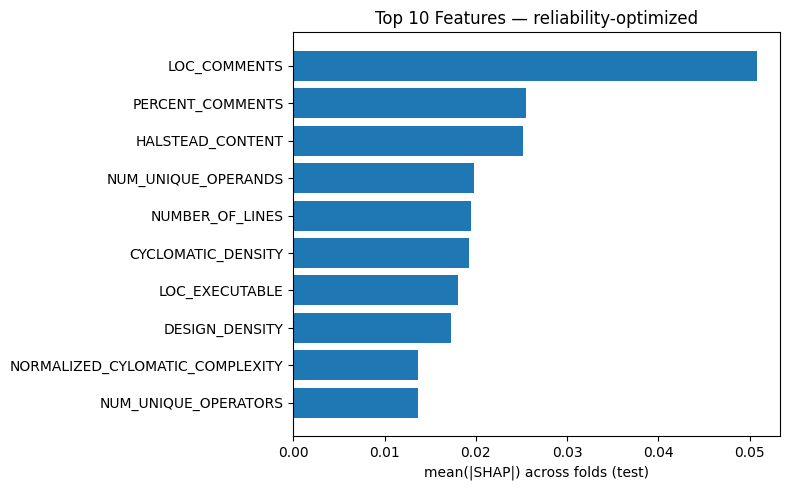

,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,0.6473,0.2339,0.2007,0.2861,0.1857,0.652,2.2,0.1403,0.5772,50


In [31]:
run_pipeline("./../../dataset/CM1.csv", model_name="RandomForest", n_splits=5)